# Applying 4-class Model to Test and Real Data

In [32]:
### python packages
import os
from os import path
import numpy as np
import glob as glob
from random import random
import pandas as pd
import pickle
import time

### torch packages
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import Sampler

### sklearn packages
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold


### remove these later (for notebook version only)
'''
from tqdm import tqdm_notebook as tqdm
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, export_png
from bokeh.layouts import row
output_notebook()
import matplotlib.pyplot as plt
import seaborn as sns
'''

torch.cuda.manual_seed(42)


In [33]:

def GetSimData(file):

    ### grab local and global views
    data_global = np.nan_to_num(np.load(file.replace('_info2.npy','_glob.npy'),encoding='latin1'))
    data_local = np.nan_to_num(np.load(file.replace('_info2.npy','_loc.npy'),encoding='latin1'))

    ### grab centroid views
    data_global_cen = data_global[:,1][np.newaxis,:]
    data_local_cen = data_local[:,1][np.newaxis,:]

    data_global = data_global[:,0][np.newaxis,:]
    data_local = data_local[:,0][np.newaxis,:]

    ### info file contains: [0]kic, [1]tce, [2]period, [3]epoch, [4]duration, [5]label)
    data_info = np.load(file,encoding='latin1')
    #np.load(self.flist_info[idx],encoding='latin1')

    if data_info[6]=='PL':
        label=1
    elif data_info[6]=='UNK':
        label=0
    elif data_info[6]=='EB':
        label=2
    else:
        label=3

    #collist=['TPERIOD','TDUR','DRRATIO','NTRANS','TSNR','TDEPTH','INDUR',
    #         'SESMES_LOG_RATIO','PRAD_LOG_RATIO','TDUR_LOG_RATIO','RADRATIO','IMPACT',
    #         'TESSMAG','RADIUS','PMTOTAL','LOGG','MH','TEFF']#from bls search, derived from transit model, from starpars
    stelpars=np.nan_to_num(np.hstack((data_info[7:13].astype(float),data_info[-18:-6].astype(float))))[np.newaxis,:]

    return (data_local.astype(float), data_global.astype(float), data_local_cen.astype(float), data_global_cen.astype(float), stelpars), label

def GetRealData(file):
    ### grab local and global views
    data_global = np.nan_to_num(np.load(file.replace('_info2.npy','_glob.npy'),encoding='latin1'))
    data_local = np.nan_to_num(np.load(file.replace('_info2.npy','_loc.npy'),encoding='latin1'))

    ### grab centroid views
    data_global_cen = data_global[:,1][np.newaxis,:]
    data_local_cen = data_local[:,1][np.newaxis,:]

    data_global = data_global[:,0][np.newaxis,:]
    data_local = data_local[:,0][np.newaxis,:]

    ### info file contains: [0]kic, [1]tce, [2]period, [3]epoch, [4]duration, [5]label)
    data_info = np.load(file,encoding='latin1')
    #np.load(self.flist_info[idx],encoding='latin1')

    #collist=['TPERIOD','TDUR','DRRATIO','NTRANS','TSNR','TDEPTH','INDUR',
    #         'SESMES_LOG_RATIO','PRAD_LOG_RATIO','TDUR_LOG_RATIO','RADRATIO','IMPACT',
    #         'TESSMAG','RADIUS','PMTOTAL','LOGG','MH','TEFF']#from bls search, derived from transit model, from starpars
    newixs=np.array([16, 24, 17, 30, 31, 21])
    stelpars=np.nan_to_num(np.hstack((data_info[newixs].astype(float),data_info[-18:-6].astype(float))))[np.newaxis,:]

    return (data_local.astype(float), data_global.astype(float), data_local_cen.astype(float), data_global_cen.astype(float), stelpars), np.nan


In [34]:
   
class Model(nn.Module):

    '''
    
    PURPOSE: DEFINE EXTRANET MODEL ARCHITECTURE
    INPUT: GLOBAL + LOCAL LIGHT CURVES AND CENTROID CURVES, STELLAR PARAMETERS
    OUTPUT: BINARY CLASSIFIER
    
    '''
    
    def __init__(self):

        ### initialize model
        super(Model, self).__init__()

        ### define global convolutional lalyer
        self.fc_global = nn.Sequential(
            nn.Conv1d(2, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(16, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(32, 64, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(64, 128, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(128, 256, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(256, 256, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
        )

        ### define local convolutional lalyer
        self.fc_local = nn.Sequential(
            nn.Conv1d(2, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(7, stride=2),
            nn.Conv1d(16, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(7, stride=2),
        )

        ### define fully connected layer that combines both views
        self.final_layer = nn.Sequential(
            nn.Linear(7858, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            ### need output of 1 because using BCE for loss
            nn.Linear(256, 4),
            nn.Softmax(1))

    def forward(self, x_local, x_local_cen, x_global, x_global_cen, x_star):
        
        x_local_all = torch.cat([x_local, x_local_cen], dim=1)
        x_global_all = torch.cat([x_global, x_global_cen], dim=1)

        ### get outputs of global and local convolutional layers
        out_global = self.fc_global(x_global_all)
        out_local = self.fc_local(x_local_all)
        
        ### flattening outputs (multi-dim tensor) from convolutional layers into vector
        out_global = out_global.view(out_global.shape[0], -1)
        out_local = out_local.view(out_local.shape[0], -1)

        ### join two outputs together
        out = torch.cat([out_global, out_local, x_star.squeeze(1)], dim=1)
        out = self.final_layer(out)

        return out

In [35]:
def make_one_hot(labels, C=2):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.
    
    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer. 
        number of classes in labels.
    
    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    if type(labels)==list or type(labels)==np.ndarray:
        target=np.zeros((len(labels),C))
        target[np.arange(len(labels)), np.array(labels).astype(int)] = 1
    else:
        one_hot = torch.cuda.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_()
        target = one_hot.scatter_(1, labels.data, 1)

        target = Variable(target)
        
    return target


In [48]:
allmodels={}
for k in range(8):
    foldname    = "/home/hosborn/TESS/final_runs/exonet_multiclass4_CV_globcents3b_k8"
    savename    = "exonet_CV_"+str(k)+".8_101_all_Big"
    savedicname = "exonet_multiclass4_CV_globcents3b_k8_dic"
    mod         = "Big"
    aug         = "all"
    fpath       = "101"
    kcount      = "0"
    #cont       = False

    #Assigning a GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"

    allmodels[k]=Model().cuda()
    lr = 2.05e-5

    optimizer = torch.optim.Adam(allmodels[k].parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    batch_size = 64
    n_epochs = 700
    
    allmodels[k].load_state_dict(torch.load(path.join(foldname,savename.replace('_comp','')+'_temp.pth')))
    
    '''
    print(savename,"Loading datasets")
    kepler_val_data = KeplerDataLoaderCrossVal(infofiles=pickle.load(open(path.join(foldname,savename+'_valfiles.pickle'),'rb')))
    kepler_train_data = KeplerDataLoaderCrossVal(infofiles=pickle.load(open(path.join(foldname,savename+'_trainfiles.pickle'),'rb')))
    kepler_batch_sampler = pickle.load(open(path.join(foldname,savename+'_BBS.pickle'),'rb'))
    kepler_data_loader = DataLoader(kepler_train_data, batch_sampler = kepler_batch_sampler, num_workers=4)
    kepler_val_loader = DataLoader(kepler_val_data, batch_size=batch_size, shuffle=False, num_workers=4)
    '''


In [49]:
test_data = SimDataLoaderCrossVal(infofiles=glob.glob('/home/hosborn/TESS/processed_dv_101_centfixed2/test/*info2.npy'))
test_data_loader = DataLoader(test_data, batch_size=batch_size, num_workers=4)

#nan_data = SimDataLoaderCrossVal(infofiles=glob.glob('/home/hosborn/TESS/processed_dv_101_centfixed2/nans/*info2.npy'))
#nan_data_loader = DataLoader(nan_data, batch_size=batch_size, num_workers=4)

real_data = RealDataLoaderCrossVal(infofiles=glob.glob('/home/hosborn/TESS/Processed_RealDat_2/*info2.npy'))
real_data_loader = DataLoader(real_data, batch_size=batch_size,num_workers=4)

real_nan_data = RealDataLoaderCrossVal(infofiles=glob.glob('/home/hosborn/TESS/Processed_RealDat_2/nans/*info2.npy'))
real_nan_data_loader = DataLoader(real_nan_data, batch_size=batch_size, num_workers=4)


In [54]:
dataloaders={'test':glob.glob('/home/hosborn/TESS/processed_dv_101_centfixed2/test/*info2.npy'),
             'real':glob.glob('/home/hosborn/TESS/Processed_RealDat_2/*info2.npy'),
             'real_nan':glob.glob('/home/hosborn/TESS/Processed_RealDat_2/nans/*info2.npy')}#,'nan':nan_data_loader
model_output={}

labels=['UNK','PL','EB','BEB']
nclasses=4

for data_loader in dataloaders:
    model_output[data_loader]=pd.DataFrame()
    
    for file in dataloaders[data_loader]:
        if data_loader=='test':
            x_data, ys = GetSimData(file)
        else:
            x_data, ys = GetRealData(file)

        ### get local view, global view, and label for training
        x_local, x_global, x_local_cent,x_global_cent, x_star = x_data

        x_local = Variable(torch.from_numpy(x_local)).type(torch.FloatTensor).cuda().unsqueeze(1)
        x_local_cent = Variable(torch.from_numpy(x_local_cent)).type(torch.FloatTensor).cuda().unsqueeze(1)
        x_global = Variable(torch.from_numpy(x_global)).type(torch.FloatTensor).cuda().unsqueeze(1)
        x_global_cent = Variable(torch.from_numpy(x_global_cent)).type(torch.FloatTensor).cuda().unsqueeze(1)
        x_star = Variable(torch.from_numpy(x_star)).type(torch.FloatTensor).cuda().unsqueeze(1)
        
        preds={}
        for k in allmodels:
            ### Looping through each model to predict:
            modout=allmodels[k](x_local, x_local_cent, x_global, x_global_cent, x_star).cpu().detach().numpy().ravel()
            
            preds.update({labels[n]+'_'+str(k):modout[n] for n in range(nclasses)})
        if data_loader is 'test':
            preds['gt']=ys
        model_output[data_loader] = model_output[data_loader].append(pd.Series(preds,name=file.split('/')[-1][:18]))
    for n in range(nclasses):
        allks=model_output[data_loader][[labels[n]+'_'+str(k) for k in range(8)]].values
        model_output[data_loader][labels[n]+'_med'] = np.nanmedian(allks,axis=1)
        model_output[data_loader][labels[n]+'_av'] = np.average(allks,axis=1)
    if data_loader is 'test':
        medvals=model_output['test'][[labels[nl]+'_med' for nl in range(nclasses)]].values
        avvals=model_output['test'][[labels[nl]+'_av' for nl in range(nclasses)]].values
        onehot=make_one_hot(model_output['test']['gt'].values,nclasses)
        print("AP: average:",average_precision_score(onehot,avallks,average='micro'))
        for n in range(nclasses):
            medvals=model_output['test'][[labels[nl]+'_med' for nl in range(nclasses)]].values
            avvals=model_output['test'][[labels[nl]+'_av' for nl in range(nclasses)]].values
            #print(labels[n],"MED accuracy:",np.sum((np.argmax(medvals,axis=1)==n)*onehot[:,n].astype(bool))/np.sum(np.argmax(medvals,axis=1)==n))
            #print(labels[n],"MED recall:",np.sum((np.argmax(medvals,axis=1)==n)*onehot[:,n].astype(bool))/np.sum(onehot[:,n]))
            #print(labels[n],"MED A.P.:", average_precision_score(onehot,medvals,average=None)[n])
            print(labels[n]," AV accuracy:",np.sum((np.argmax(avvals,axis=1)==n)*onehot[:,n].astype(bool))/np.sum(np.argmax(avvals,axis=1)==n))
            print(labels[n]," AV recall:",np.sum((np.argmax(avvals,axis=1)==n)*onehot[:,n].astype(bool))/np.sum(onehot[:,n]))
            print(labels[n]," AV A.P.:", average_precision_score(onehot,avvals,average=None)[n])


AP: [0.9784861  0.94486492 0.94663112 0.91748077]  average: 0.9632202029806928


In [55]:
pickle.dump(model_output,open('4classmod.pickle','wb'))

AP: average: 0.9632202029806928
UNK  AV accuracy: 0.9463452566096423
UNK  AV recall: 0.9545098039215686
UNK  AV A.P.: 0.9784861020935041
PL  AV accuracy: 0.890625
PL  AV recall: 0.8883116883116883
PL  AV A.P.: 0.9448649150724617
EB  AV accuracy: 0.8743169398907104
EB  AV recall: 0.9169054441260746
EB  AV A.P.: 0.9466311234826916
BEB  AV accuracy: 0.8850931677018633
BEB  AV recall: 0.8166189111747851
BEB  AV A.P.: 0.9174807699755355


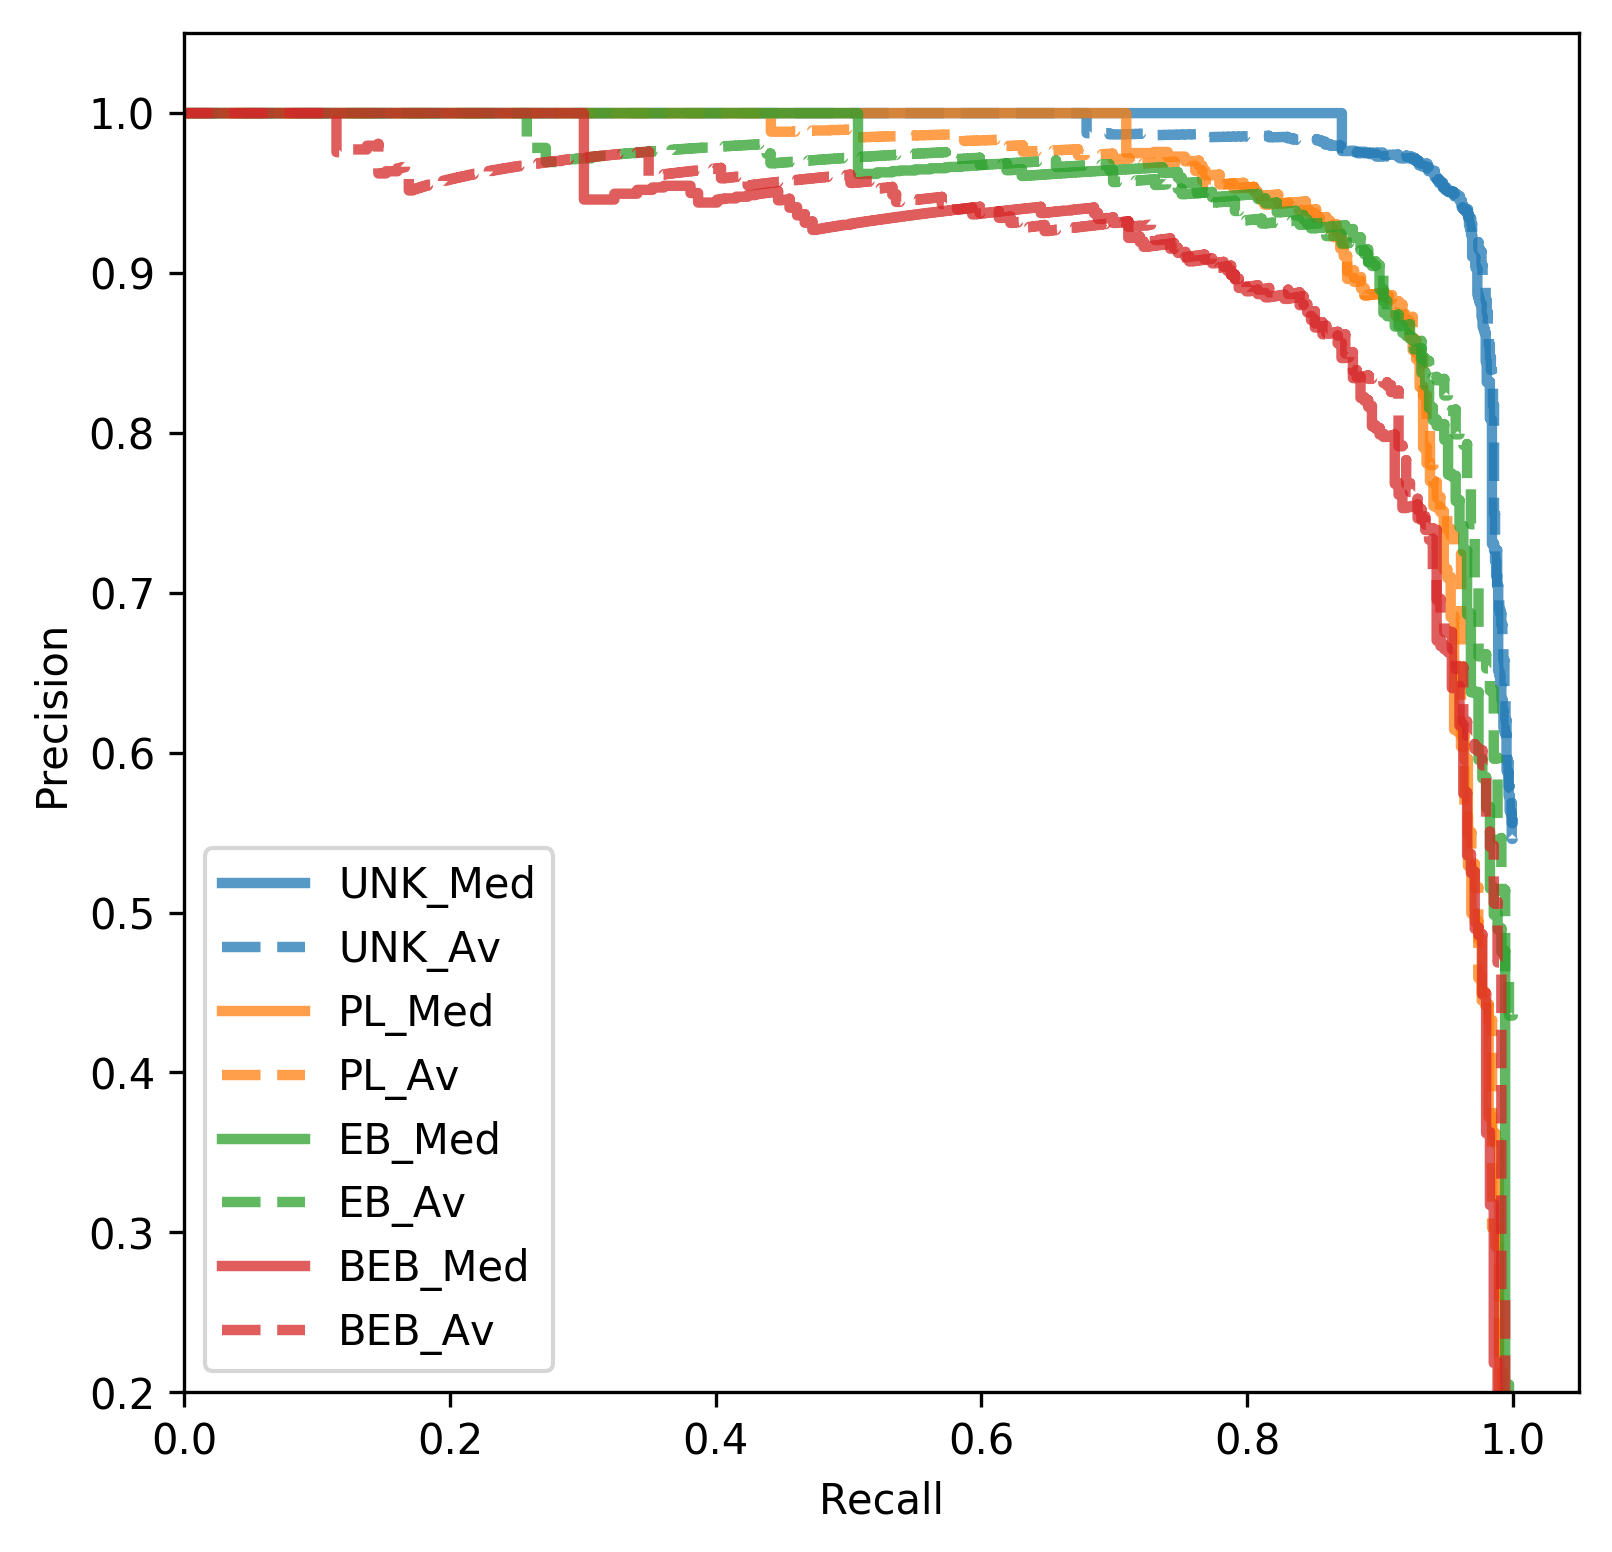

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

plt.figure(figsize=(6,6))

labels=['UNK','PL','EB','BEB']
one_hot_gt=make_one_hot(model_output['test']['gt'].values,nclasses)
### plot values
for n in range(nclasses):
    P, R, _ =precision_recall_curve(one_hot_gt[:,n],medvals[:,n])
    steps=plt.step(R, P,label=labels[n]+'_Med',linewidth=2.5,alpha=0.75)
    P, R, _ =precision_recall_curve(one_hot_gt[:,n],avvals[:,n])
    plt.step(R, P,label=labels[n]+'_Av',linewidth=2.5,linestyle='--',color=steps[0].get_color(),alpha=0.75)
plt.legend()
plt.xlim(0.0,1.05)
plt.ylim(0.2,1.05)
plt.xlabel('Recall')
plt.ylabel('Precision')
savefile='4class_ensemble_testdat_avmedcomp'
plt.savefig(path.join('/home/hosborn/TESS/PaperFigures',savefile+'_PR.png'))
plt.savefig(path.join('/home/hosborn/TESS/PaperFigures',savefile+'_PR.pdf'))

In [21]:
dataloaders={'test':test_data_loader,'real':real_data_loader,'real_nan':real_nan_data_loader}#,'nan':nan_data_loader
model_output={}
for data_loader in dataloaders:
    model_output[data_loader]={}
    if data_loader is 'test':
        gt=np.zeros(4)

    for k in range(8):
        model_output[data_loader][k]=np.zeros((4,4))

    for x_data, ys in dataloaders[data_loader]:

        ### get local view, global view, and label for training
        x_local, x_global, x_local_cent,x_global_cent, x_star = x_data

        x_local = Variable(x_local).type(torch.FloatTensor).cuda().unsqueeze(1)
        x_local_cent = Variable(x_local_cent).type(torch.FloatTensor).cuda().unsqueeze(1)
        x_global = Variable(x_global).type(torch.FloatTensor).cuda().unsqueeze(1)
        x_global_cent = Variable(x_global_cent).type(torch.FloatTensor).cuda().unsqueeze(1)
        x_star = Variable(x_star).type(torch.FloatTensor).cuda().unsqueeze(1)

        for k in allmodels:
            ### Looping through each model to predict:
            pred=allmodels[k](x_local, x_local_cent, x_global, x_global_cent, x_star)
            model_output[data_loader][k] = np.vstack((model_output[data_loader][k],pred.cpu().detach().numpy()))
        if data_loader is 'test':
            gt=np.hstack((gt,ys))

    allpreds=[]
    for k in model_output[data_loader]:
        model_output[data_loader][k]=model_output[data_loader][k][4:]
        allpreds+=[model_output[data_loader][k]]
    allpreds=np.dstack((allpreds))
    model_output[data_loader]['med']=np.nanmedian(allpreds,axis=2)
    model_output[data_loader]['av']=np.average(allpreds,axis=2)
    if data_loader is 'test':
        gt=gt[4:]
        print("AP:",average_precision_score(make_one_hot(gt,4),model_output[data_loader]['av'],average=None)
              ," average:",average_precision_score(make_one_hot(gt,4),model_output[data_loader]['av'],average='micro'))


AP: [0.96226211 0.90032044 0.90142705 0.85852318]  average: 0.9337383322740341


In [24]:
onehot=make_one_hot(gt,4)

In [30]:
for n in range(4):
    print(n,"AV recall:",np.sum((np.argmax(model_output['test']['av'],axis=1)==n)*onehot[:,n].astype(bool))/np.sum(onehot[:,n]))
    print(n,"MED recall:",np.sum((np.argmax(model_output['test']['med'],axis=1)==n)*onehot[:,n].astype(bool))/np.sum(onehot[:,n]))
    print(n,"AV accuracy:",np.sum((np.argmax(model_output['test']['av'],axis=1)==n)*onehot[:,n].astype(bool))/np.sum(np.argmax(model_output['test']['av'],axis=1)==n))
    print(n,"MED accuracy:",np.sum((np.argmax(model_output['test']['med'],axis=1)==n)*onehot[:,n].astype(bool))/np.sum(np.argmax(model_output['test']['av'],axis=1)==n))
    

0 recall: 0.9325490196078431
0 accuracy: 0.9512
1 recall: 0.9012987012987013
1 accuracy: 0.8631840796019901
2 recall: 0.8853868194842407
2 accuracy: 0.8373983739837398
3 recall: 0.7994269340974212
3 accuracy: 0.827893175074184


In [31]:
np.save('model_gt.npy',gt)

In [27]:
len(model_output[data_loader]['av'])

2197

In [29]:
len(gt)

2358

In [19]:
pickle.dump(model_output,open('4classmod.pickle','wb'))

In [17]:
np.save('real_nan_idlist4.npy',real_nan_data.ids)
np.save('real_idlist4.npy',real_data.ids)